In [1]:
from irt import IRT
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
target_models = ['meta-llama/Llama-3.2-3B-Instruct',
                 'Qwen/Qwen2.5-1.5B-Instruct',
                 'Qwen/Qwen2.5-3B-Instruct',
                 'HuggingFaceTB/SmolLM2-1.7B-Instruct',
                 'mistralai/Mistral-7B-Instruct-v0.3',
                 'google/gemma-2-2b-it']

## Data

In [3]:
df_new = pd.read_parquet("hf://datasets/open-llm-leaderboard/contents/data/train-00000-of-00001.parquet")
df_old = pd.read_parquet("hf://datasets/open-llm-leaderboard-old/contents/data/train-00000-of-00001-96886cb34a7bc800.parquet")
df_old.loc[:,['ARC', 'HellaSwag', 'MMLU', 'TruthfulQA', 'Winogrande', 'GSM8K']] = df_old.loc[:,['ARC', 'HellaSwag', 'MMLU', 'TruthfulQA', 'Winogrande', 'GSM8K']]/100
df_old.shape,df_new.shape

((7260, 26), (4576, 36))

In [4]:
df_old = df_old.dropna()
df_new = df_new.dropna()
df_old.shape,df_new.shape

((6966, 26), (4576, 36))

In [5]:
np.percentile(df_old.loc[:,['ARC', 'HellaSwag', 'MMLU', 'TruthfulQA', 'Winogrande', 'GSM8K']],[10],axis=0)

array([[0.32935154, 0.52843059, 0.26010908, 0.39149452, 0.5801105 ,
        0.0030326 ]])

In [6]:
np.percentile(df_new.loc[:,['IFEval Raw', 'BBH Raw', 'MATH Lvl 5 Raw', 'GPQA Raw', 'MUSR Raw', 'MMLU-PRO Raw']],[10],axis=0)

array([[0.18302548, 0.31590304, 0.01359517, 0.25755034, 0.34342708,
        0.12130153]])

In [7]:
idx_old = (df_old.GSM8K>.05)*(df_old.TruthfulQA>.4) # (df_old.ARC>.2)*(df_old.HellaSwag>.5)*(df_old.MMLU>.25)*(df_old.TruthfulQA>.4)*(df_old.Winogrande>.6)*(df_old.GSM8K>.02)
idx_new = (df_new['IFEval Raw']>.1) #*(df_new['BBH Raw']>.3)*(df_new['MATH Lvl 5 Raw']>.02)*(df_new['GPQA Raw']>.25)*(df_new['MUSR Raw']>.35)*(df_new['MMLU-PRO Raw']>.01)

In [8]:
df_old = df_old.loc[idx_old]
df_new = df_new.loc[idx_new]
df_old.shape,df_new.shape

((5133, 26), (4489, 36))

In [9]:
df = df_old.merge(df_new, on='fullname', how='outer')

In [10]:
scores = ['ARC', 'HellaSwag', 'MMLU', 'TruthfulQA', 'Winogrande', 'GSM8K','IFEval Raw', 'BBH Raw', 'MATH Lvl 5 Raw', 'GPQA Raw', 'MUSR Raw', 'MMLU-PRO Raw']
#scores = ['ARC', 'HellaSwag', 'MMLU', 'TruthfulQA', 'Winogrande', 'GSM8K']
#scores = ['IFEval Raw', 'BBH Raw', 'MATH Lvl 5 Raw', 'GPQA Raw', 'MUSR Raw', 'MMLU-PRO Raw']

df = df.loc[:,['fullname']+scores]

Y = np.array(df.iloc[:,1:])
mask = ~np.isnan(Y) #training mask: non-missing patterns

Checking if target models are in the data

In [11]:
[m in list(df.fullname) for m in target_models]

[True, True, True, True, True, True]

## Fitting IRT

In [12]:
irt = IRT(ds=[1,2,3,4,5], device='cuda')
irt.fit(Y, mask, lrs=[1,.1,.01], tol=0, n_epochs=5000)
irt.rotate()

Training IRT models for different d's.:   0%|          | 0/5 [00:00<?, ?it/s]

Training IRT models with d=1 and different lr's.:   0%|          | 0/3 [00:00<?, ?it/s]

Training IRT with d=1 and lr=1.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=1, tol=0, train loss=0.21582, val loss=0.17717, val MAE=0.17717, val acc=0.81755, lr=1.00000
epoch=0100, d=1, tol=0, train loss=0.05573, val loss=0.07198, val MAE=0.07198, val acc=0.87664, lr=1.00000
epoch=0200, d=1, tol=0, train loss=0.04713, val loss=0.05569, val MAE=0.05569, val acc=0.89357, lr=0.81451
epoch=0300, d=1, tol=0, train loss=0.03731, val loss=0.05334, val MAE=0.05334, val acc=0.90359, lr=0.66342
epoch=0400, d=1, tol=0, train loss=0.03681, val loss=0.05291, val MAE=0.05291, val acc=0.90532, lr=0.56880
Early stop at epoch 472 - best val loss 0.05208 - val MAE 0.05208 - best epoch 372


Training IRT with d=1 and lr=0.1.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=1, tol=0, train loss=0.21582, val loss=0.17067, val MAE=0.17067, val acc=0.61610, lr=0.10000
epoch=0100, d=1, tol=0, train loss=0.03442, val loss=0.05302, val MAE=0.05302, val acc=0.90498, lr=0.10000
epoch=0200, d=1, tol=0, train loss=0.03370, val loss=0.05250, val MAE=0.05250, val acc=0.90532, lr=0.09500
Early stop at epoch 292 - best val loss 0.05234 - val MAE 0.05234 - best epoch 192


Training IRT with d=1 and lr=0.01.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=1, tol=0, train loss=0.21582, val loss=0.20859, val MAE=0.20859, val acc=0.53974, lr=0.01000
epoch=0100, d=1, tol=0, train loss=0.07447, val loss=0.08223, val MAE=0.08223, val acc=0.84658, lr=0.01000
epoch=0200, d=1, tol=0, train loss=0.04080, val loss=0.05731, val MAE=0.05731, val acc=0.89046, lr=0.01000
epoch=0300, d=1, tol=0, train loss=0.03638, val loss=0.05625, val MAE=0.05625, val acc=0.89806, lr=0.00903
Early stop at epoch 360 - best val loss 0.05595 - val MAE 0.05595 - best epoch 260


Training IRT models with d=2 and different lr's.:   0%|          | 0/3 [00:00<?, ?it/s]

Training IRT with d=2 and lr=1.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=2, tol=0, train loss=0.20747, val loss=0.21282, val MAE=0.21282, val acc=0.72460, lr=1.00000
epoch=0100, d=2, tol=0, train loss=0.04265, val loss=0.07282, val MAE=0.07282, val acc=0.87111, lr=1.00000
epoch=0200, d=2, tol=0, train loss=0.03548, val loss=0.05969, val MAE=0.05969, val acc=0.90083, lr=0.85737
Early stop at epoch 258 - best val loss 0.05362 - val MAE 0.05362 - best epoch 158


Training IRT with d=2 and lr=0.1.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=2, tol=0, train loss=0.20747, val loss=0.16238, val MAE=0.16238, val acc=0.62992, lr=0.10000
epoch=0100, d=2, tol=0, train loss=0.01997, val loss=0.04761, val MAE=0.04761, val acc=0.91189, lr=0.10000
Early stop at epoch 188 - best val loss 0.04714 - val MAE 0.04714 - best epoch 88


Training IRT with d=2 and lr=0.01.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=2, tol=0, train loss=0.20747, val loss=0.19991, val MAE=0.19991, val acc=0.52004, lr=0.01000
epoch=0100, d=2, tol=0, train loss=0.04655, val loss=0.06210, val MAE=0.06210, val acc=0.88079, lr=0.01000
epoch=0200, d=2, tol=0, train loss=0.02798, val loss=0.05295, val MAE=0.05295, val acc=0.89357, lr=0.01000
epoch=0300, d=2, tol=0, train loss=0.02198, val loss=0.05083, val MAE=0.05083, val acc=0.90083, lr=0.01000
epoch=0400, d=2, tol=0, train loss=0.01980, val loss=0.05049, val MAE=0.05049, val acc=0.90187, lr=0.00950
Early stop at epoch 488 - best val loss 0.05043 - val MAE 0.05043 - best epoch 388


Training IRT models with d=3 and different lr's.:   0%|          | 0/3 [00:00<?, ?it/s]

Training IRT with d=3 and lr=1.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=3, tol=0, train loss=0.20546, val loss=0.23388, val MAE=0.23388, val acc=0.67726, lr=1.00000
epoch=0100, d=3, tol=0, train loss=0.06175, val loss=0.07577, val MAE=0.07577, val acc=0.84727, lr=1.00000
epoch=0200, d=3, tol=0, train loss=0.05897, val loss=0.07579, val MAE=0.07579, val acc=0.87042, lr=0.81451
Early stop at epoch 218 - best val loss 0.06928 - val MAE 0.06928 - best epoch 118


Training IRT with d=3 and lr=0.1.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=3, tol=0, train loss=0.20546, val loss=0.16419, val MAE=0.16419, val acc=0.62543, lr=0.10000
epoch=0100, d=3, tol=0, train loss=0.01348, val loss=0.05064, val MAE=0.05064, val acc=0.90463, lr=0.09500
Early stop at epoch 170 - best val loss 0.05001 - val MAE 0.05001 - best epoch 70


Training IRT with d=3 and lr=0.01.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=3, tol=0, train loss=0.20546, val loss=0.19773, val MAE=0.19773, val acc=0.54457, lr=0.01000
epoch=0100, d=3, tol=0, train loss=0.03900, val loss=0.06026, val MAE=0.06026, val acc=0.88355, lr=0.01000
epoch=0200, d=3, tol=0, train loss=0.02055, val loss=0.05409, val MAE=0.05409, val acc=0.89979, lr=0.01000
epoch=0300, d=3, tol=0, train loss=0.01564, val loss=0.05255, val MAE=0.05255, val acc=0.90809, lr=0.01000
epoch=0400, d=3, tol=0, train loss=0.01369, val loss=0.05262, val MAE=0.05262, val acc=0.90670, lr=0.00903
Early stop at epoch 442 - best val loss 0.05235 - val MAE 0.05235 - best epoch 342


Training IRT models with d=4 and different lr's.:   0%|          | 0/3 [00:00<?, ?it/s]

Training IRT with d=4 and lr=1.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=4, tol=0, train loss=0.20747, val loss=0.27183, val MAE=0.27183, val acc=0.61714, lr=1.00000
epoch=0100, d=4, tol=0, train loss=0.05835, val loss=0.08291, val MAE=0.08291, val acc=0.86628, lr=1.00000
epoch=0200, d=4, tol=0, train loss=0.04888, val loss=0.07709, val MAE=0.07709, val acc=0.85902, lr=0.85737
epoch=0300, d=4, tol=0, train loss=0.02994, val loss=0.05666, val MAE=0.05666, val acc=0.88943, lr=0.81451
epoch=0400, d=4, tol=0, train loss=0.02783, val loss=0.05856, val MAE=0.05856, val acc=0.88286, lr=0.66342
Early stop at epoch 404 - best val loss 0.05331 - val MAE 0.05331 - best epoch 304


Training IRT with d=4 and lr=0.1.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=4, tol=0, train loss=0.20747, val loss=0.16604, val MAE=0.16604, val acc=0.59157, lr=0.10000
epoch=0100, d=4, tol=0, train loss=0.01140, val loss=0.05238, val MAE=0.05238, val acc=0.89806, lr=0.09025
Early stop at epoch 146 - best val loss 0.04963 - val MAE 0.04963 - best epoch 46


Training IRT with d=4 and lr=0.01.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=4, tol=0, train loss=0.20747, val loss=0.20081, val MAE=0.20081, val acc=0.53732, lr=0.01000
epoch=0100, d=4, tol=0, train loss=0.02940, val loss=0.05713, val MAE=0.05713, val acc=0.89496, lr=0.01000
epoch=0200, d=4, tol=0, train loss=0.01488, val loss=0.05043, val MAE=0.05043, val acc=0.91085, lr=0.01000
epoch=0300, d=4, tol=0, train loss=0.01252, val loss=0.05068, val MAE=0.05068, val acc=0.90809, lr=0.00815
Early stop at epoch 316 - best val loss 0.05036 - val MAE 0.05036 - best epoch 216


Training IRT models with d=5 and different lr's.:   0%|          | 0/3 [00:00<?, ?it/s]

Training IRT with d=5 and lr=1.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=5, tol=0, train loss=0.20592, val loss=0.26394, val MAE=0.26394, val acc=0.65895, lr=1.00000
epoch=0100, d=5, tol=0, train loss=0.08752, val loss=0.10960, val MAE=0.10960, val acc=0.82930, lr=0.95000
epoch=0200, d=5, tol=0, train loss=0.07358, val loss=0.09221, val MAE=0.09221, val acc=0.83345, lr=0.85737
epoch=0300, d=5, tol=0, train loss=0.05800, val loss=0.07447, val MAE=0.07447, val acc=0.85487, lr=0.81451
epoch=0400, d=5, tol=0, train loss=0.05355, val loss=0.07313, val MAE=0.07313, val acc=0.86040, lr=0.69834
epoch=0500, d=5, tol=0, train loss=0.05683, val loss=0.07393, val MAE=0.07393, val acc=0.86213, lr=0.59874
epoch=0600, d=5, tol=0, train loss=0.05263, val loss=0.07170, val MAE=0.07170, val acc=0.86075, lr=0.51334
epoch=0700, d=5, tol=0, train loss=0.05143, val loss=0.07020, val MAE=0.07020, val acc=0.86351, lr=0.44013
Early stop at epoch 724 - best val loss 0.06895 - val MAE 0.06895 - best epoch 624


Training IRT with d=5 and lr=0.1.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=5, tol=0, train loss=0.20592, val loss=0.16460, val MAE=0.16460, val acc=0.61403, lr=0.10000
epoch=0100, d=5, tol=0, train loss=0.00902, val loss=0.04757, val MAE=0.04757, val acc=0.90187, lr=0.10000
epoch=0200, d=5, tol=0, train loss=0.00684, val loss=0.05190, val MAE=0.05190, val acc=0.90221, lr=0.08145
Early stop at epoch 208 - best val loss 0.04733 - val MAE 0.04733 - best epoch 108


Training IRT with d=5 and lr=0.01.:   0%|          | 0/5000 [00:00<?, ?it/s]

epoch=0000, d=5, tol=0, train loss=0.20592, val loss=0.19943, val MAE=0.19943, val acc=0.54181, lr=0.01000
epoch=0100, d=5, tol=0, train loss=0.02029, val loss=0.05849, val MAE=0.05849, val acc=0.89254, lr=0.01000
epoch=0200, d=5, tol=0, train loss=0.01138, val loss=0.05633, val MAE=0.05633, val acc=0.89461, lr=0.00903
Early stop at epoch 244 - best val loss 0.05598 - val MAE 0.05598 - best epoch 144

Standardizing Theta...

Best d=2 - best val loss=0.04714


## Plotting results with different rotations

In [15]:
idx_models = [np.argmax(np.array(df.fullname)==m) for m in target_models]

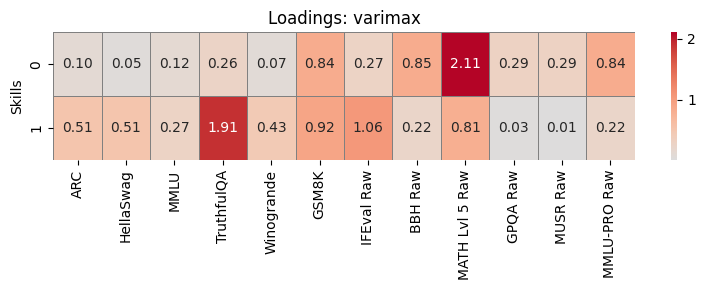

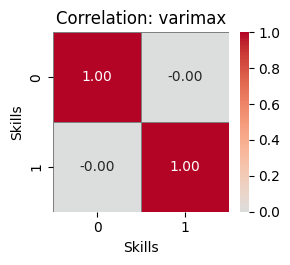

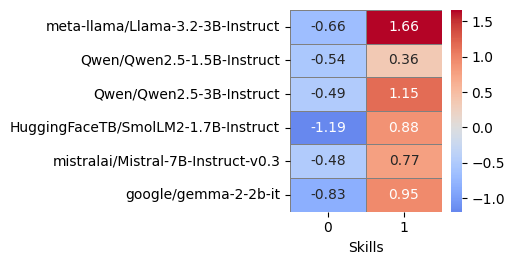

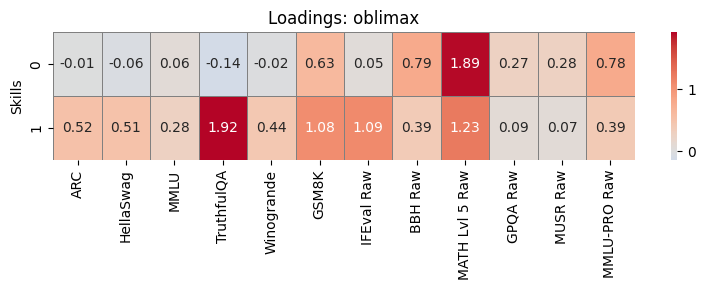

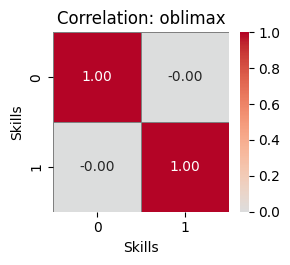

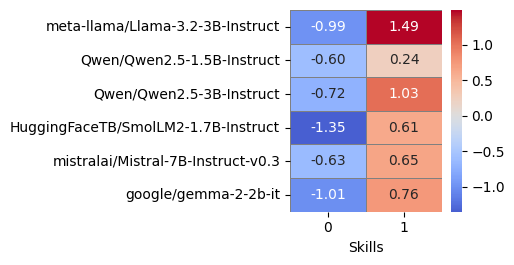

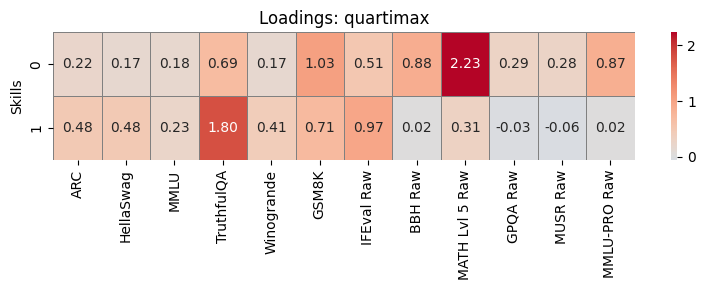

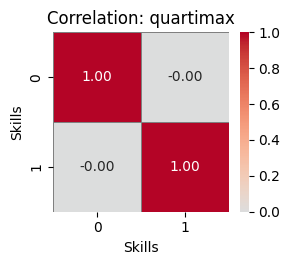

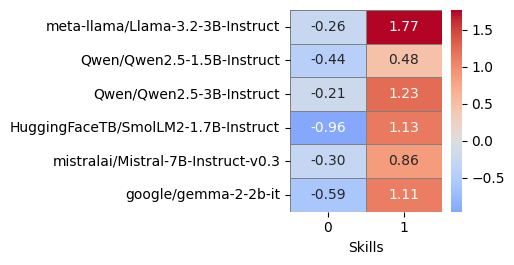

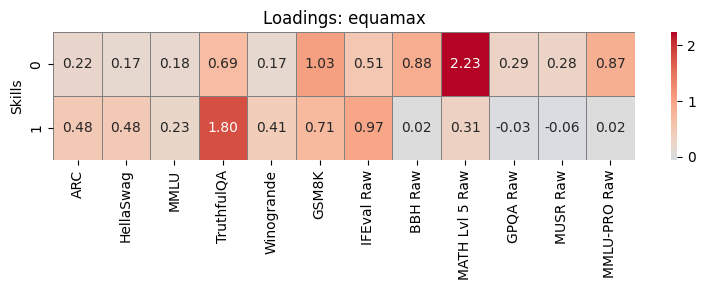

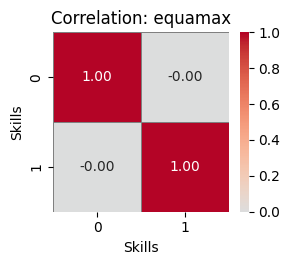

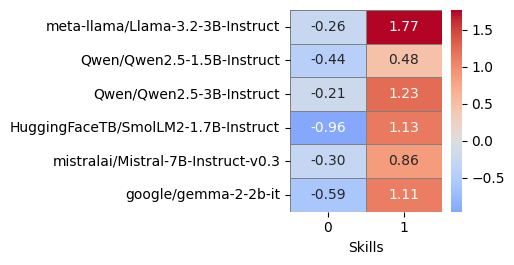

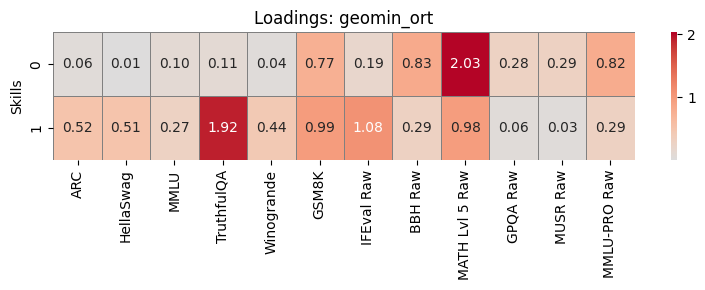

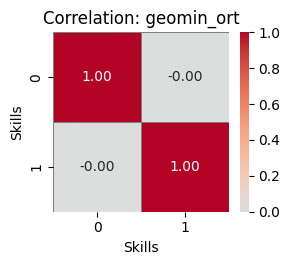

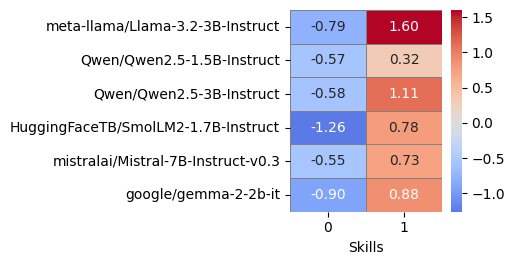

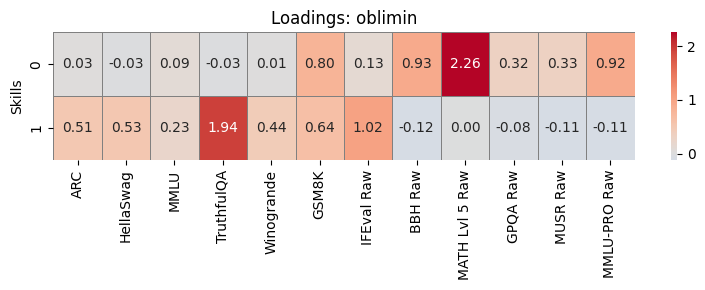

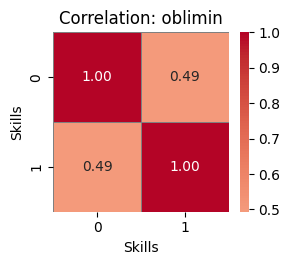

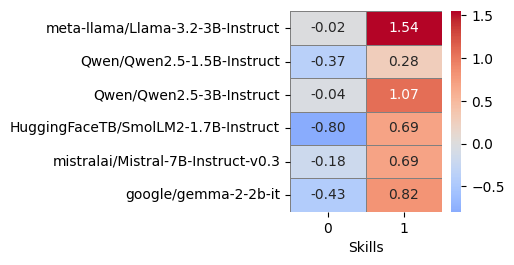

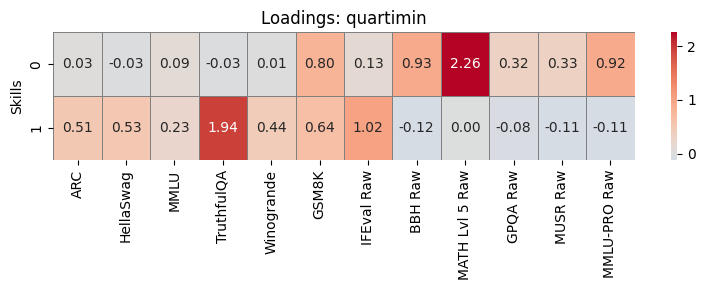

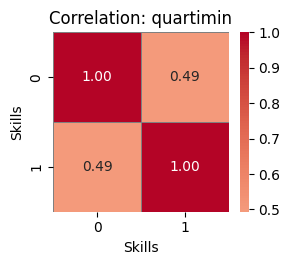

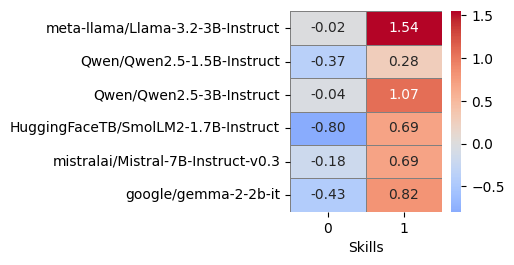

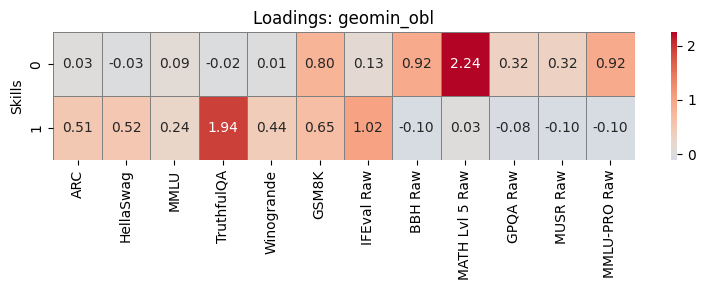

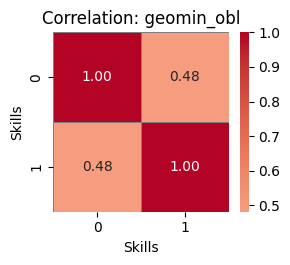

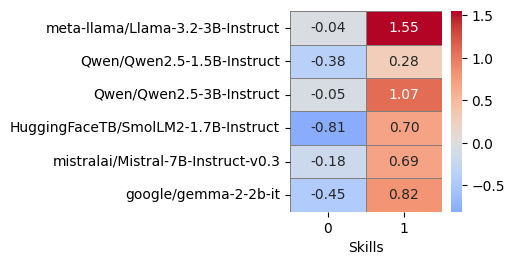

In [16]:
for rotation in irt.Alpha_rot.keys():
    sign=np.array([[int(np.sign(irt.Alpha_rot[rotation][i,j])) for j,i in enumerate(np.abs(irt.Alpha_rot[rotation]).argmax(0))]])
    
    plt.figure(figsize=(8, 3))
    sns.heatmap(
        (sign*irt.Alpha_rot[rotation]).T,
        cmap='coolwarm',     # cold‑to‑warm diverging palette
        annot=True,          # write the data value in each cell
        fmt=".2f",           # formatting for the numbers
        linewidths=0.5,      # lines between cells
        linecolor='gray',    # color of the lines
        center=0             # center the colormap at zero (if data is diverging)
    )
    
    plt.ylabel("Skills")
    plt.title(f"Loadings: {rotation}")
    plt.xticks(ticks=np.array(list(range(len(scores))))+.5, labels=scores, rotation=90)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(3, 2.75))
    sns.heatmap(
        np.corrcoef((sign*irt.Theta_rot[rotation]).T),
        cmap='coolwarm',     # cold‑to‑warm diverging palette
        annot=True,          # write the data value in each cell
        fmt=".2f",           # formatting for the numbers
        linewidths=0.5,      # lines between cells
        linecolor='gray',    # color of the lines
        center=0             # center the colormap at zero (if data is diverging)
    )
    
    plt.ylabel("Skills")
    plt.xlabel("Skills")
    plt.title(f"Correlation: {rotation}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 2.75))
    sns.heatmap(
        (sign*irt.Theta_rot[rotation])[idx_models],
        cmap='coolwarm',     # cold‑to‑warm diverging palette
        annot=True,          # write the data value in each cell
        fmt=".2f",           # formatting for the numbers
        linewidths=0.5,      # lines between cells
        linecolor='gray',    # color of the lines
        center=0             # center the colormap at zero (if data is diverging)
    )
    
    plt.xlabel("Skills")
    plt.yticks(ticks=np.array(list(range(len(target_models))))+.5, labels=target_models, rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\n\n\n\n")